In [4]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns; sns.set()
import os
import pandas_profiling
import holidays
import geopy
import scipy
import datetime
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin, ClusterMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

### Data exploration

In [64]:
# Loading our dataset and adding in the output for data exploration
problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()

X_test = X_df
X_test["output"] = y_array

In [7]:
# Creating a dictionary to map airports by State
airports_to_states = {'ATL' : 'Georgia',
                     'ORD':'Illinois',
                     'LAX':'California',
                     'DFW':'Texas',
                     'DEN':'Colorado',
                     'JFK':'New York',
                     'SFO':'California',
                     'CLT':'North Carolina',
                     'LAS':'Nevada',
                     'PHX':'Arizona',
                     'IAH':'Texas',
                     'MIA':'Florida',
                     'MCO':'Florida',
                     'EWR':'New Jersey',
                     'SEA':'Washington',
                     'MSP':'Minnesota',
                     'DTW':'Michigan',
                     'PHL':'Pennsylvania',
                     'BOS':'Massachusetts',
                     'LGA':'New York'}

# Mapping our airports to a State
X_test["d_State"] = X_test["Departure"].map(airports_to_states)
X_test["a_State"] = X_test["Arrival"].map(airports_to_states)

In [34]:
# Getting a look at our average departure data grouped by State
departure_airport = X_test.groupby("Departure").mean()
departure_airport.reset_index(level=0, inplace=True)
departure_airport.columns = ["AirPort","d_avg_WeeksToDeparture","d_avg_stdwtd","d_avg_output"]
departure_airport

AirPort  d_avg_WeeksToDeparture  d_avg_stdwtd  d_avg_output
0      ATL               10.675858      8.327480     10.998076
1      BOS                9.927851      7.603612     10.970770
2      CLT                8.972627      7.118236     10.517327
3      DEN               10.768583      8.022705     10.682832
4      DFW               10.625290      8.114157     10.928303
5      DTW                9.529886      7.485846     10.573318
6      EWR               11.236410      8.674750     10.737355
7      IAH               11.695305      8.991462     10.691555
8      JFK               14.750340     10.484949     11.254418
9      LAS               13.089016      9.430775     10.760347
10     LAX               13.684890     10.050442     11.412482
11     LGA                9.698485      7.434576     11.400049
12     MCO               13.451341      9.709406     10.860733
13     MIA               13.507754     10.033411     10.600538
14     MSP               10.433643      8.141208     10.894052
15     ORD               11.317439      8.569810     11.272394
16     PHL                9.910833      7.466866     10.765409
17     PHX               10.819439      8.225828     10.599330
18     SEA               11.244874      8.564081     10.774392
19     SFO               12.578138      9.289769     11.226658

10.817562147122162


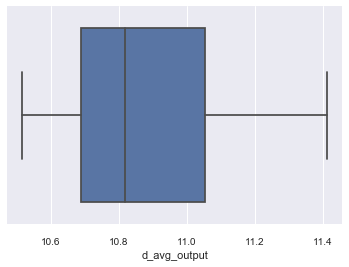

In [39]:
# This boxplot indicates that some high values for departure skew our boxplot to the right
import seaborn as sns
sns.boxplot(x=departure_airport['d_avg_output'])

# Printing the exact value of the median for our reference
print(departure_airport["d_avg_output"].median())

In [41]:
# Extracting the quantiles of order 0.25 and 0.75 to see where extreme values lie
departure_lower_bound = np.quantile(departure_airport['d_avg_output'],q = 0.25)
departure_higher_bound = np.quantile(departure_airport['d_avg_output'],q = 0.75)

# Printing the higher bound since we know the data is skewed to the right
departure_higher_bound

11.055221284769882

In [48]:
# Getting a look at our average arrival data grouped by State
arrival_airport = X_test.groupby("Arrival").mean()
arrival_airport.reset_index(level=0, inplace=True)
arrival_airport.columns = ["AirPort","a_avg_WeeksToDeparture","a_avg_stdwtd","a_avg_output"]
arrival_airport

AirPort  a_avg_WeeksToDeparture  a_avg_stdwtd  a_avg_output
0      ATL               10.621225      8.365852     10.930859
1      BOS                9.920096      7.570086     10.883722
2      CLT                8.717532      6.936280     10.593840
3      DEN               10.830305      8.118785     10.694978
4      DFW               10.787892      8.128654     11.082126
5      DTW                9.360042      7.420424     10.570704
6      EWR               11.661976      8.881995     10.795281
7      IAH               11.618637      8.695985     10.578128
8      JFK               14.979395     10.644953     11.525112
9      LAS               12.843552      9.331298     10.659832
10     LAX               13.433921      9.885150     11.434573
11     LGA               10.173531      7.823405     11.310172
12     MCO               13.806001      9.869701     10.808384
13     MIA               13.253110      9.808616     10.668731
14     MSP               10.422192      7.916349     10.824109
15     ORD               11.263108      8.536739     11.257095
16     PHL                9.940684      7.594698     10.695155
17     PHX               10.265659      7.646319     10.585008
18     SEA               11.599992      8.690999     10.829093
19     SFO               12.343008      9.217518     11.226356

10.816246382738031


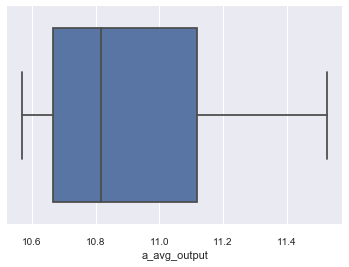

In [49]:
# This boxplot indicates two outlier States: California and New York, which we will weight heavier than the rest 
sns.boxplot(x=arrival_airport['a_avg_output'])
print(arrival_airport["a_avg_output"].median())

In [50]:
# Extracting the quantiles of order 0.25 and 0.75 to see where extreme values lie
arrival_lower_bound = np.quantile(arrival_state['a_avg_output'],q = 0.25)
arrival_higher_bound = np.quantile(arrival_state['a_avg_output'],q = 0.75)

# Printing the higher bound since we know the data is skewed to the right
arrival_higher_bound

11.118183583397897

In [18]:
# Getting a profile report on X test to drive our heuristics
X_test.profile_report()

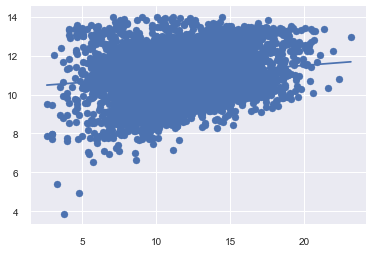

In [44]:
# Testing whether the number of weeks people book before departure explains the traffic well 
# We observe that there is a positive correlation between both albeit not very high
x = X_test["WeeksToDeparture"]
y = X_test["output"]

plt.scatter(x,y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

#### Visual representation of the data

In [15]:
import plotly.graph_objects as go
import pandas as pd

df_airports = 

df_flight_paths = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_february_aa_flight_paths.csv')
df_flight_paths.head()

fig = go.Figure()

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_airports['long'],
    lat = df_airports['lat'],
    hoverinfo = 'text',
    text = df_airports['airport'],
    mode = 'markers',
    marker = dict(
        size = 2,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

flight_paths = []
for i in range(len(df_flight_paths)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = [df_flight_paths['start_lon'][i], df_flight_paths['end_lon'][i]],
            lat = [df_flight_paths['start_lat'][i], df_flight_paths['end_lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            opacity = float(df_flight_paths['cnt'][i]) / float(df_flight_paths['cnt'].max()),
        )
    )

fig.update_layout(
    title_text = 'Feb. 2011 American Airline flight paths<br>(Hover for airport names)',
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'north america',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()

### Feature extractors

In [4]:
# Baseline Feature extractor
class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
        X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
        X_weather = X_weather.rename(
            columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})
        X_encoded = pd.merge(
            X_encoded, X_weather, how='left',
            left_on=['DateOfDeparture', 'Arrival'],
            right_on=['DateOfDeparture', 'Arrival'],
            sort=False)

        X_encoded = X_encoded.join(pd.get_dummies(
            X_encoded['Departure'], prefix='d'))
        X_encoded = X_encoded.join(
            pd.get_dummies(X_encoded['Arrival'], prefix='a'))
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)

        X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
        X_array = X_encoded.values
        return X_array

In [ ]:
# Baseline regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
class Regressor2(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(
            n_estimators=20, max_depth=50, max_features=10)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [ ]:
# Combined regressor 
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(n_estimators=200)
        self.reg2 = Lasso()
        self.reg3 = LassoLars()
        self.reg4 = Ridge()
        self.reg5 = LinearRegression()
        self.reg6 = BayesianRidge()
        self.metareg = RandomForestRegressor(n_estimators=200)

    def fit(self, X, y):
        self.reg.fit(X,y)
        self.reg2.fit(X,y)
        self.reg3.fit(X,y)
        self.reg4.fit(X,y)
        self.reg5.fit(X,y)
        self.reg6.fit(X,y)
        X_combined = np.vstack([self.reg.predict(X), self.reg2.predict(X),self.reg3.predict(X),self.reg4.predict(X),self.reg5.predict(X)]).T
        self.metareg.fit(X_combined, y)


    def predict(self, X):
        pred1 = self.reg.predict(X)
        pred2 = self.reg2.predict(X)
        pred3 = self.reg3.predict(X)
        pred4 = self.reg4.predict(X)
        pred5 = self.reg5.predict(X)
        pred6 = self.reg6.predict(X)
        X_combined = np.vstack([pred1, pred2, pred3, pred4, pred5, pred6]).T
        return self.metareg.predict(X_combined)

In [72]:
# Feature extractor to date
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import math 
import numpy as np

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        
        ## External data processing
        #external_data = pd.read_csv(os.path.join(path,'external_data.csv'))
        external_data = pd.read_csv("external_data.csv")
        external_data.loc[:,"Date"] = pd.to_datetime(external_data.loc[:,"Date"])
        
        # Building column names for conditions at departure and arrival 
        col_dep = ['d_' + name for name in list(external_data.columns)]
        col_arr = [w.replace('d_', 'a_') for w in col_dep]
        
        # Fitting the names of the first 2 columns to match our original dataframe 
        col_dep = [w.replace('d_AirPort', 'Departure') for w in col_dep]
        col_dep = [w.replace('d_Date', 'DateOfDeparture') for w in col_dep]
        col_arr = [w.replace('a_AirPort', 'Arrival') for w in col_arr]
        col_arr = [w.replace('a_Date', 'DateOfDeparture') for w in col_arr]
        
        # Building 2 dataframes from data_add to get the information for the departure and arrival airports of each flight
        # Departure airport 
        external_dataDeparture = external_data.copy()
        external_dataDeparture.columns = col_dep
        # Arrival airport
        external_dataArrival = external_data.copy()
        external_dataArrival.columns = col_arr
        
        # Merging them with X_encoded 
        X_encoded = X_df.copy()
        X_encoded.loc[:,'DateOfDeparture'] = pd.to_datetime(X_encoded.loc[:,'DateOfDeparture'])
        X_encoded = pd.merge(X_encoded, external_dataDeparture, how='left',left_on=['DateOfDeparture', 'Departure'],
                             right_on=['DateOfDeparture', 'Departure'],sort=False)
        X_encoded = pd.merge(X_encoded, external_dataArrival, how='left',left_on=['DateOfDeparture', 'Arrival'],
                             right_on=['DateOfDeparture', 'Arrival'],sort=False) 
        
        ### Feature engineering
        ## Creating columns to distinguish between the two main airports for flights and the rest
        X_encoded['d_ManyFlights'] = 0  
        X_encoded['a_ManyFlights'] = 0
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ORD', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ORD', "a_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ATL', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ATL', "a_ManyFlights"] = 1
        
        ## Creating the distance variable
        # Creating latitude and longitude difference for the purpose of computing distance. 
        radius = 6371
        X_encoded["latitude_difference"] = (X_encoded["d_latitude_deg"] - X_encoded["a_latitude_deg"])
        X_encoded["longitude_difference"] = (X_encoded["d_longitude_deg"] - X_encoded["a_longitude_deg"])
        # Creating my distance column
        n,p = X_encoded.shape
        X_encoded["Distance"] = 0
        # Getting the indexes I will need 
        j = X_encoded.columns.get_loc("d_latitude_deg")
        l = X_encoded.columns.get_loc("a_latitude_deg")
        o = X_encoded.columns.get_loc("d_longitude_deg")
        t = X_encoded.columns.get_loc("a_longitude_deg")
        u = X_encoded.columns.get_loc("latitude_difference")
        v = X_encoded.columns.get_loc("longitude_difference")

        for i in np.arange(n):
            lat1 = X_encoded.iloc[i,j]
            lat2 = X_encoded.iloc[i,l]
            lon1 = X_encoded.iloc[i,o]
            lon2 = X_encoded.iloc[i,t]
            dlat = math.radians(X_encoded.iloc[i,u])
            dlon = math.radians(X_encoded.iloc[i,v])
            a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
            d = radius * c
            X_encoded.iloc[i,-1] = d
        # Now dropping latitude and longitude difference
        X_encoded = X_encoded.drop(columns={"latitude_difference", "longitude_difference"})

        
        ## Categorical encoding of departure and arrival airports
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Departure'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Arrival'], prefix='a'))
                                   
        ## Categorical encoding of the dates 
        X_encoded['year'] = X_encoded.loc[:,'DateOfDeparture'].dt.year
        X_encoded['month'] = X_encoded.loc[:,'DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded.loc[:,'DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded.loc[:,'DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded.loc[:,'DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded.loc[:,'DateOfDeparture'].apply(lambda date: 
                                                                         (date - pd.to_datetime("1970-01-01")).days)
        
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))

    
        # Finally getting rid of departure, arrival, and date columns now that we do not need them to merge
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)
        X_encoded = X_encoded.drop('DateOfDeparture',axis = 1)
        
    
        return X_encoded

In [8]:
# Combined regressor 
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=205,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
        self.reg2 = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='ls', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False)
        self.reg3 = 
        self.metareg = RandomForestRegressor(n_estimators=200)

    def fit(self, X, y):
        self.reg.fit(X,y)
        self.reg2.fit(X,y)
        self.reg3.fit(X,y)
        self.reg4.fit(X,y)
        self.reg5.fit(X,y)
        X_combined = np.vstack([self.reg.predict(X), self.reg2.predict(X),self.reg3.predict(X),self.reg3.predict(X),
                                self.reg5.predict(X)]).T
        self.metareg.fit(X_combined, y)


    def predict(self, X):
        pred1 = self.reg.predict(X)
        pred2 = self.reg2.predict(X)
        pred3 = self.reg3.predict(X)
        pred4 = self.reg4.predict(X)
        pred5 = self.reg5.predict(X)
        X_combined = np.vstack([pred1, pred2, pred3, pred4,pred5]).T
        return self.metareg.predict(X_combined)

In [14]:
# Gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import BaseEstimator
class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = GradientBoostingRegressor(learning_rate = 0.2,n_estimators = 300)

    def fit(self, X, y):
        self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

In [2]:
# Choosing which feature extractor we want to fit the data on in this notebook
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook

__file__ = 'submissions/starting_kit/'
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_encoded = fe.transform(X_df)

NameError: name 'FeatureExtractor' is not defined

In [32]:
X_encoded.head()

WeeksToDeparture    std_wtd     output  d_Max TemperatureC  \
0            12.875000   9.812647  12.331296                  35   
1            14.285714   9.466734  10.775182                  36   
2            10.863636   9.035883  11.083177                   6   
3            11.480000   7.990202  11.169268                  22   
4            11.450000   9.517159  11.269364                   8   
5            10.363636   8.232025  12.073649                   7   
6            15.266667   9.808277  11.173936                  18   
7             8.588235   6.165010   9.599952                   9   
8            10.238095   6.609877   9.175645                  32   
9             8.294118   5.542616  10.734320                  11   
10           12.600000   9.725396  10.769399                  27   
11            8.933333   9.407191  12.336303                  -6   
12           13.629630   9.178353  10.267310                  36   
13           12.807692   8.129055  12.667558                  23   
14            9.900000   6.608607  12.879062                  18   
15           10.565217   7.590820  10.561284                  12   
16           13.760000   9.955233  10.649808                  11   
17            7.000000   4.472136  11.757644                   9   
18           12.875000   9.665323  10.515395                  27   
19            9.842105   7.819230  10.914216                  17   
20           10.523810   7.138761  10.919567                  13   
21            9.833333   8.304853  11.251560                   6   
22           16.068966  10.347294  10.213472                  28   
23            6.153846   4.180234  11.364360                  32   
24           11.000000   8.711759  11.740518                  19   
25            8.684211   6.700353  11.552416                  23   
26           14.035714   8.971073  11.401869                  22   
27            8.133333   6.289068  12.113513                  19   
28            8.176471   6.616601  11.529438                  23   
29           13.960000  10.921996  10.624941                  36   
...                ...        ...        ...                 ...   
8872         14.208333  11.057082   9.834016                  34   
8873         14.192308  10.248977  10.722479                  11   
8874          8.944444   5.985003   9.963324                  21   
8875         14.304348  12.700876  11.834458                  31   
8876          8.235294   7.611910  11.141010                  20   
8877         11.125000   7.792485  12.336303                  36   
8878         16.181818  11.541920  12.984415                  29   
8879         11.913043   8.696462  10.205652                  26   
8880         13.080000   9.091755  12.559850                  12   
8881         12.708333   9.317954  12.397778                   2   
8882         14.000000  11.131786  11.923892                  19   
8883         15.615385  11.950153  10.282411                  22   
8884         11.173913   7.068832  10.174042                  27   
8885         13.240000  11.140317  10.427055                   8   
8886         12.695652   9.546226  11.552416                  16   
8887         11.833333   9.448564  12.526286                   3   
8888         14.576923  11.552223  12.800827                  25   
8889          9.823529   8.048566  11.355921                  15   
8890         10.476190   7.131753  11.368565                  10   
8891          8.625000   6.333772  12.409833                  -1   
8892         12.363636  10.759472  11.150477                  22   
8893          8.500000   5.338539  11.256027                  13   
8894         14.000000  10.743215  12.351243                  24   
8895          9.473684   6.501012  10.125598                  24   
8896         12.846154  10.479284  10.854314                  11   
8897          9.263158   7.316967  10.427055                  17   
8898         12.772727  10.641034  12.201552                  

### Mapping heuristic columns

#### Singling out airports from States with most traffic

In [930]:
# Printing a classification of arrival States according to traffic intensity 
n,p = departure_state.shape
for i in np.arange(n):
    cond = departure_state["output"][i]
    if cond>departure_higher_bound:
        print(departure_state.index[i],":",1)
    else:
        if cond<departure_higher_bound:
            print(departure_state.index[i],":",-1)
        else:
            print(departure_state.index[i],":",0) 


d_TrafficIntensity = {
"Arizona" : "-0.5",
"California" : "1",
"Colorado" : "-0.5",
"Florida" : "-0.5",
"Georgia" : "1",
"Illinois" : "1",
"Massachusetts" : "-0.5",
"Michigan" : "-0.5",
"Minnesota" : "-0.5",
"Nevada" : "-0.5",
"New Jersey" : "-0.5",
"New York" : "1",
"North Carolina" : "-0.5",
"Pennsylvania" : "-0.5",
"Texas" : "-0.5",
"Washington" : "-0.5"}

ATL : -1
BOS : -1
CLT : -1
DEN : -1
DFW : -1
DTW : -1
EWR : -1
IAH : -1
JFK : 1
LAS : -1
LAX : 1
LGA : 1
MCO : -1
MIA : -1
MSP : -1
ORD : 1
PHL : -1
PHX : -1
SEA : -1
SFO : 1


In [931]:
# Printing a classification of arrival States according to traffic intensity
n,p = arrival_state.shape
for i in np.arange(n):
    cond = arrival_state["output"][i]
    if cond>arrival_higher_bound:
        print(arrival_state.index[i],1)
    else:
        if cond<arrival_higher_bound:
            print(arrival_state.index[i],-1)
        else:
            print(arrival_state.index[i],0)

# From this, creating my dictionary
a_TrafficIntensity = {
"Arizona" : "-0.5",
"California" : "2",
"Colorado" : "-0.5",
"Florida" : "-0.5",
"Georgia" : "-0.5",
"Illinois" : "2",
"Massachusetts" : "-0.5",
"Michigan" : "-0.5",
"Minnesota" : "-0.5",
"Nevada" : "-0.5",
"New Jersey" : "-0.5",
"New York" : "2",
"North Carolina" : "-0.5",
"Pennsylvania" : "-0.5",
"Texas" : "1",
"Washington" : "-0.5"}

ATL : -1
BOS : -1
CLT : -1
DEN : -1
" DFW ": " 1 "
DTW : -1
EWR : -1
IAH : -1
" JFK ": " 1 "
LAS : -1
" LAX ": " 1 "
" LGA ": " 1 "
MCO : -1
MIA : -1
MSP : -1
" ORD ": " 1 "
PHL : -1
PHX : -1
SEA : -1
" SFO ": " 1 "


In [932]:
# Correcting state approximations by adding information on the individual airports
# Might not be used in the feature extractor
d_busy_airport = {
    'ATL':"0",
    'ORD':"0",
    'LAX':"0",
    'DFW':"1",
    'DEN':"1",
    'JFK':"0",
    'SFO':"0",
    'CLT':"0",
    'LAS':"0",
    'PHX':"0",
    'IAH':"0",
    'MIA':"0",
    'MCO':"1",
    'EWR':"1",
    'SEA':"0",
    'MSP':"0",
    'DTW':"0",
    'PHL':"0.5",
    'BOS':"1",
    'LGA': "0"}
a_busy_airport = { 
    'ATL':"1",
    'ORD':"0.5",
    'LAX':"1",
    'DFW':"1",
    'DEN':"1",
    'JFK':"0",
    'SFO':"0",
    'CLT':"0",
    'LAS':"0",
    'PHX':"0",
    'IAH':"0",
    'MIA':"0",
    'MCO':"0.5",
    'EWR':"0",
    'SEA':"0",
    'MSP':"0",
    'DTW':"0",
    'PHL':"0",
    'BOS':"1",
    'LGA': "0"}

In [970]:
# Building auxiliary columns from dictionaries to help my heuristics
X_test["heuristics_airports"] = 0
X_test["departure_importance"] = X_test["d_State"].map(d_TrafficIntensity)
X_test["arrival_importance"] = X_test["a_State"].map(a_TrafficIntensity)
X_test["arrival_airportImportance"] = X_test["Arrival"].map(a_busy_airport)
X_test["departure_airportImportance"] = X_test["Departure"].map(d_busy_airport)

# It seems that when both are big airports, the traffic is less important so I am taking this into account
check = X_test["arrival_airportImportance"].astype(float) + X_test["departure_airportImportance"].astype(float)
X_test["departure_arrival_big"] =  (check>1.25)*0.25

# Heuristics column
X_test["heuristics_airports"] = X_test["departure_importance"].astype(float)+ X_test["arrival_importance"].astype(float) + X_test["arrival_airportImportance"].astype(float) + X_test["departure_airportImportance"].astype(float)-X_test["departure_arrival_big"]

# Finally dropping the auxiliary columns
X_test = X_test.drop(columns = {"departure_importance", "arrival_importance","departure_airportImportance",
                       "arrival_airportImportance", "departure_arrival_big" })

X_test.head()

DateOfDeparture Departure Arrival  WeeksToDeparture   std_wtd     output  \
0      2012-06-19       ORD     DFW         12.875000  9.812647  12.331296   
1      2012-09-10       LAS     DEN         14.285714  9.466734  10.775182   
2      2012-10-05       DEN     LAX         10.863636  9.035883  11.083177   
3      2011-10-09       ATL     ORD         11.480000  7.990202  11.169268   
4      2012-02-21       DEN     SFO         11.450000  9.517159  11.269364   

    d_State     a_State  heuristics_airports  departure_arrival_big  \
0  Illinois       Texas                    0                   0.00   
1    Nevada    Colorado                    0                   0.00   
2  Colorado  California                    0                   0.75   
3   Georgia    Illinois                    0                   0.00   
4  Colorado  California                    0                   0.00   

  departure_importance arrival_importance arrival_airportImportance  \
0                    1                  1                         1   
1                 -0.5               -0.5                         1   
2                 -0.5                  2                         1   
3                    1                  2                       0.5   
4                 -0.5                  2                         0   

  departure_airportImportance  
0                           0  
1                           0  
2                           1  
3                           0  
4                           1

In [ ]:
#X_test[X_test["output"]>11][X_test["heuristics_airports"]<0]

In [ ]:
#X_test[X_test["output"]<9][X_test["heuristics_airports"]>2]

#### The section of code that will be used in the feature encoder

In [56]:
# What I am going to add to the feature encoder
airports_to_states = {'ATL' : 'Georgia',
                     'ORD':'Illinois',
                     'LAX':'California',
                     'DFW':'Texas',
                     'DEN':'Colorado',
                     'JFK':'New York',
                     'SFO':'California',
                     'CLT':'North Carolina',
                     'LAS':'Nevada',
                     'PHX':'Arizona',
                     'IAH':'Texas',
                     'MIA':'Florida',
                     'MCO':'Florida',
                     'EWR':'New Jersey',
                     'SEA':'Washington',
                     'MSP':'Minnesota',
                     'DTW':'Michigan',
                     'PHL':'Pennsylvania',
                     'BOS':'Massachusetts',
                     'LGA':'New York'}
X_encoded["d_State"] = X_encoded["Departure"].map(airports_to_states)
X_encoded["a_State"] = X_encoded["Arrival"].map(airports_to_states)

# Initialising weights based on state by looking at the quantiles by departure and arrival State in X_df with output
d_TrafficIntensity = {
"Arizona" : "-0.5",
"California" : "1",
"Colorado" : "-0.5",
"Florida" : "-0.5",
"Georgia" : "1",
"Illinois" : "1",
"Massachusetts" : "-0.5",
"Michigan" : "-0.5",
"Minnesota" : "-0.5",
"Nevada" : "-0.5",
"New Jersey" : "-0.5",
"New York" : "1",
"North Carolina" : "-0.5",
"Pennsylvania" : "-0.5",
"Texas" : "-0.5",
"Washington" : "-0.5"}

a_TrafficIntensity = {
"Arizona" : "-0.5",
"California" : "2",
"Colorado" : "-0.5",
"Florida" : "-0.5",
"Georgia" : "-0.5",
"Illinois" : "2",
"Massachusetts" : "-0.5",
"Michigan" : "-0.5",
"Minnesota" : "-0.5",
"Nevada" : "-0.5",
"New Jersey" : "-0.5",
"New York" : "2",
"North Carolina" : "-0.5",
"Pennsylvania" : "-0.5",
"Texas" : "1",
"Washington" : "-0.5"}

# Correcting state approximations with busiest airports, by looking at my extreme errors
d_busy_airport = {
    'ATL':"0",
    'ORD':"0",
    'LAX':"0",
    'DFW':"1",
    'DEN':"1",
    'JFK':"0",
    'SFO':"0",
    'CLT':"0",
    'LAS':"0",
    'PHX':"0",
    'IAH':"0",
    'MIA':"0",
    'MCO':"1",
    'EWR':"1",
    'SEA':"0",
    'MSP':"0",
    'DTW':"0",
    'PHL':"0.5",
    'BOS':"1",
    'LGA': "0"}


a_busy_airport = { 
    'ATL':"1",
    'ORD':"0.5",
    'LAX':"1",
    'DFW':"1",
    'DEN':"1",
    'JFK':"0",
    'SFO':"0",
    'CLT':"0",
    'LAS':"0",
    'PHX':"0",
    'IAH':"0",
    'MIA':"0",
    'MCO':"0.5",
    'EWR':"0",
    'SEA':"0",
    'MSP':"0",
    'DTW':"0",
    'PHL':"0",
    'BOS':"1",
    'LGA': "0"}

# Auxiliary columns from dictionaries to help my heuristics
X_encoded["heuristics_airports"] = 0
X_encoded["departure_importance"] = X_encoded["d_State"].map(d_TrafficIntensity)
X_encoded["arrival_importance"] = X_encoded["a_State"].map(a_TrafficIntensity)
X_encoded["arrival_airportImportance"] = X_encoded["Arrival"].map(a_busy_airport)
X_encoded["departure_airportImportance"] = X_encoded["Departure"].map(d_busy_airport)

# It seems that when both are big airports, the traffic is less important so I am taking this into account
check = X_encoded["arrival_airportImportance"].astype(float) + X_encoded["departure_airportImportance"].astype(float)
X_encoded["departure_arrival_big"] =  (check>1.25)*0.25

# Heuristics column
X_encoded["heuristics_airports"] = X_encoded["departure_importance"].astype(float)+ X_encoded["arrival_importance"].astype(float) + X_encoded["arrival_airportImportance"].astype(float) + X_encoded["departure_airportImportance"].astype(float)-X_encoded["departure_arrival_big"]

# Dropping the auxiliary columns
X_encoded = X_encoded.drop(columns = {"departure_importance", "arrival_importance","departure_airportImportance",
                       "arrival_airportImportance", "departure_arrival_big" })

KeyError: 'Departure'

### New try at heuristics using directly the means of groupby airport on X_df

In [51]:
external_data = pd.read_csv("submissions/sarvic_2311_1920_merge_de_nos_versions/external_data.csv")
external_data2 = pd.merge(external_data, departure_airport, how='left',left_on=['AirPort'], right_on=['AirPort'],sort=False)
external_data2 = pd.merge(external_data, arrival_airport, how='left',left_on=['AirPort'], right_on=['AirPort'],sort=False)
external_data = external_data2
external_data.head()

In [73]:
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_encoded = fe.transform(X_df)
X_encoded.head()

KeyboardInterrupt: 

In [75]:
X_encoded["departure_arrival_interaction"] = X_encoded.loc[:,"d_avg_output"]*X_encoded.loc[:,"d_avg_output"]

In [76]:
external_data.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0  2011-09-01     ATL                35              18            79   
1  2011-09-02     ATL                36              15            61   
2  2011-09-03     ATL                35              16            64   
3  2011-09-04     ATL                27              19            93   
4  2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  Weekday  Weekend  Weekend_approx  Busiest_top5  \
0  49340732           56840.0        3        0               0             1   
1  49340732           56840.0        4        0               1             1   
2  49340732           56840.0        5        1               0             1   
3  49340732           56840.0        6        1               1             1   
4  49340732           56840.0        0        0               0             1   

   National_holidays  State_holidays  OtherAirports  M  N  S  W  \
0                  0               0              0  0  0  1  0   
1                  0               0              0  0  0  1  0   
2                  0               0              0  0  0  1  0   
3                  0               0              0  0  0  1  0   
4                  1               1              0  0  0  1  0   

   a_avg_WeeksToDeparture  a_avg_stdwtd  a_avg_output  d_avg_WeeksToDeparture  \
0               10.621225      8.365852     10.930859               10.675858   
1               10.621225      8.365852     10.930859               10.675858   
2               10.621225      8.365852     10.930859               10.675858   
3               10.621225      8.365852     10.930859               10.675858   
4               10.621225      8.365852     10.930859               10.675858   

   d_avg_stdwtd  d_avg_output  
0       8.32748     10.998076  
1       8.32748     10.998076  
2       8.32748     10.998076  
3       8.32748     10.998076  
4       8.32748     10.998076

### Interaction column for week-end, holidays and long week-end

In [101]:
external_data["WeekEndApproxHoliday_interaction"] = external_data.loc[:,"State_holidays"]*external_data.loc[:,"Weekend_approx"]
external_data["WeekEndApproxHoliday_interaction"].sum()

110

In [102]:
external_data["WeekEndHoliday_interaction"] = external_data.loc[:,"State_holidays"]*external_data.loc[:,"Weekend"]
external_data["WeekEndHoliday_interaction"].sum()

77

### Distances between airports

In [ ]:
X_test["d_State"] = X_test["Departure"].map(airports_to_states)

In [77]:
import math 
# Creating latitude and longitude difference for the purpose of computing distance. We will drop them later on 
radius = 6371
X_encoded["latitude_difference"] = (X_encoded["d_latitude_deg"] - X_encoded["a_latitude_deg"])
X_encoded["longitude_difference"] = (X_encoded["d_longitude_deg"] - X_encoded["a_longitude_deg"])

# Creating my distance column
n,p = X_encoded.shape
X_encoded["Distance"] = 0

# Getting the indexes I will need 
j = X_encoded.columns.get_loc("d_latitude_deg")
l = X_encoded.columns.get_loc("a_latitude_deg")
o = X_encoded.columns.get_loc("d_longitude_deg")
t = X_encoded.columns.get_loc("a_longitude_deg")
u = X_encoded.columns.get_loc("latitude_difference")
v = X_encoded.columns.get_loc("longitude_difference")

for i in np.arange(n):
    lat1 = X_encoded.iloc[i,j]
    lat2 = X_encoded.iloc[i,l]
    lon1 = X_encoded.iloc[i,o]
    lon2 = X_encoded.iloc[i,t]
    dlat = math.radians(X_encoded.iloc[i,u])
    dlon = math.radians(X_encoded.iloc[i,v])
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    X_encoded.iloc[i,-1] = d

# Now dropping latitude and longitude difference
X_encoded = X_encoded.drop(columns={"latitude_difference", "longitude_difference"})

### Long week-ends

In [667]:
external_data = pd.read_csv("submissions/sarvic_2011_0935/external_data.csv")
external_data.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0  2011-09-01     ATL                35              18            79   
1  2011-09-02     ATL                36              15            61   
2  2011-09-03     ATL                35              16            64   
3  2011-09-04     ATL                27              19            93   
4  2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  interestFlightPrices  
0  49340732           56840.0                  80.0  
1  49340732           56840.0                  80.0  
2  49340732           56840.0                  80.0  
3  49340732           56840.0                  80.0  
4  49340732           56840.0                  80.0

In [668]:
# Getting the datetime formats for external data
external_data.loc[:,'Date'] = pd.to_datetime(external_data.loc[:,'Date'])    
j = external_data.columns.get_loc("Date")

# Initialising my prolonged week-end column
external_data["LongWeekEnd"] = 0
k = external_data.columns.get_loc("LongWeekEnd")

# Singling out the Friday
n,p = external_data.shape
for i in np.arange(n): 
    date = external_data.iloc[i,j]
    weekno = date.weekday()
    if weekno==4:
        external_data.iloc[i,k] = 1
    else:
        external_data.iloc[i,k] = 0  
print("First step completed")

# Singling out the Sunday now
n,p = external_data.shape
for i in np.arange(n): 
    date = external_data.iloc[i,j]
    weekno = date.weekday()
    if weekno==6:
        external_data.iloc[i,k] = 1
    else:
        external_data.iloc[i,k] = external_data.iloc[i,k]
external_data.head()

First step completed


Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0 2011-09-01     ATL                35              18            79   
1 2011-09-02     ATL                36              15            61   
2 2011-09-03     ATL                35              16            64   
3 2011-09-04     ATL                27              19            93   
4 2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  interestFlightPrices  LongWeekEnd  
0  49340732           56840.0                  80.0            0  
1  49340732           56840.0                  80.0            1  
2  49340732           56840.0                  80.0            0  
3  49340732           56840.0                  80.0            1  
4  49340732           56840.0                  80.0            0

### States & regions

In [103]:
# Extracting the States by airport to make a dictionary of them
# Creating an auxiliary dataframe
geog = external_data.loc[:,'latitude_deg':'longitude_deg']
geog["AirPort"] = external_data['AirPort']
geog["Date"] = external_data["Date"]


geolocator = Nominatim(timeout=3,user_agent="test_sarah") # increased the timeout threshold to avoid the error

X = geog['AirPort'].unique()
latitudes = geog['latitude_deg'].unique()
longitudes = geog['longitude_deg'].unique()

p = X.shape
a = 0
for i in np.arange(p[0]):
    location = geolocator.reverse((latitudes[i].astype(str),longitudes[i].astype(str)))
    location = location[0].split(sep =",")
    print(X[i],location[-3])

ATL  Georgia
ORD  Illinois
LAX  California
DFW  Texas
DEN  Denver County
JFK  New York
SFO  California
CLT  North Carolina
LAS  Nevada
PHX  Arizona
IAH  Texas
MIA  Florida
MCO  Florida
EWR  New Jersey
SEA  Washington
MSP  Minnesota
DTW  Michigan
PHL  Pennsylvania
BOS  Massachusetts
LGA  New York


In [670]:
airports_to_states = {'ATL' : 'Georgia',
                     'ORD':'Illinois',
                     'LAX':'California',
                     'DFW':'Texas',
                     'DEN':'Colorado',
                     'JFK':'New York',
                     'SFO':'California',
                     'CLT':'North Carolina',
                     'LAS':'Nevada',
                     'PHX':'Arizona',
                     'IAH':'Texas',
                     'MIA':'Florida',
                     'MCO':'Florida',
                     'EWR':'New Jersey',
                     'SEA':'Washington',
                     'MSP':'Minnesota',
                     'DTW':'Michigan',
                     'PHL':'Pennsylvania',
                     'BOS':'Massachusetts',
                     'LGA':'New York'}

In [671]:
dictionary = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'}
# I have to invert this dictionary which I got from the internet
states_to_abbreviations = {y:x for x,y in dictionary.items()}

In [672]:
# Will be useful to affect regions to the airports
abbreviations_to_regions = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

In [715]:
external_data["States"] = external_data["AirPort"].map(airports_to_states)
external_data["States"] = external_data["States"].map(states_to_abbreviations)

In [674]:
external_data['Region'] = external_data['States'].map(abbreviations_to_regions)

In [675]:
external_data.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0 2011-09-01     ATL                35              18            79   
1 2011-09-02     ATL                36              15            61   
2 2011-09-03     ATL                35              16            64   
3 2011-09-04     ATL                27              19            93   
4 2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  interestFlightPrices  LongWeekEnd States Region  
0  49340732           56840.0                  80.0            0     GA      S  
1  49340732           56840.0                  80.0            1     GA      S  
2  49340732           56840.0                  80.0            0     GA      S  
3  49340732           56840.0                  80.0            1     GA      S  
4  49340732           56840.0                  80.0            0     GA      S

### Holiday

In [676]:
# Getting the holidays for each State, by name
import holidays
geolocator = Nominatim(timeout=3,user_agent="test_sarah")
external_data["Holiday"] = 0

n,p = external_data.shape
for i in np.arange(n):
    state = external_data.iloc[i,external_data.columns.get_loc("States")] # getting the State name
    us_holidays = holidays.CountryHoliday('US', prov=None, state=state) # getting the holidays for given State
    date = external_data.iloc[i,external_data.columns.get_loc("Date")] # getting the date to test
    #a = date in us_holidays # returns a boolean if this is true 
    a = us_holidays.get(date)
    #external_data.iloc[i,external_data.columns.get_loc("Holiday")] = a*1 # setting the boolean to 0 ou 1
    external_data.iloc[i,external_data.columns.get_loc("Holiday")] = a # setting the name of the holiday

In [677]:
external_data["Holiday"][external_data["Holiday"].isna()] = "NoHoliday"

In [57]:
#external_data["Holiday"].unique()

In [682]:
# Singling out the most important holidays by manual selection
special_events = ['Christmas Day',
'Christmas Day (Observed)',
'Christmas Eve',
'Christmas Eve (Observed)',
'Day After Christmas',
'Day After Christmas, Christmas Day (Observed)',
'Day After Thanksgiving'
'Friday After Thanksgiving',
'Independence Day'
"New Year's Day", "New Year's Day (Observed)",'Thanksgiving']

In [683]:
# Giving them a bigger importance than other holidays with a for loop
n,p = external_data.shape
for i in np.arange(n):
    if external_data.iloc[i,32]=="NoHoliday":
        external_data.iloc[i,32] = 0
    else:
        if external_data.iloc[i,32] in special_events:
            external_data.iloc[i,32] = 2
        else: 
            external_data.iloc[i,32] = 1  

In [684]:
external_data.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0 2011-09-01     ATL                35              18            79   
1 2011-09-02     ATL                36              15            61   
2 2011-09-03     ATL                35              16            64   
3 2011-09-04     ATL                27              19            93   
4 2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  interestFlightPrices  LongWeekEnd States  \
0  49340732           56840.0                  80.0            0     GA   
1  49340732           56840.0                  80.0            1     GA   
2  49340732           56840.0                  80.0            0     GA   
3  49340732           56840.0                  80.0            1     GA   
4  49340732           56840.0                  80.0            0     GA   

  Region  Holiday  
0      S        0  
1      S        0  
2      S        0  
3      S        0  
4      S        1

In [688]:
external_data = external_data.drop(columns = {"interestFlightPrices"})

#### OLD -  Holiday ID

In [509]:
# I saved the file with the holidays earlier, calling it TEST
external_data = pd.read_csv("external_dataTEST.csv")

In [514]:
external_data

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0      2011-09-01     ATL                35              18            79   
1      2011-09-02     ATL                36              15            61   
2      2011-09-03     ATL                35              16            64   
3      2011-09-04     ATL                27              19            93   
4      2011-09-05     ATL                26              22            94   
5      2011-09-06     ATL                24              15            90   
6      2011-09-07     ATL                21              14            93   
7      2011-09-08     ATL                23              13            87   
8      2011-09-09     ATL                27              12            93   
9      2011-09-10     ATL                29              11            84   
10     2011-09-11     ATL                30              11            72   
11     2011-09-12     ATL                31              13            73   
12     2011-09-13     ATL                32              13            78   
13     2011-09-14     ATL                33              12            63   
14     2011-09-15     ATL                30              15            78   
15     2011-09-16     ATL                22              11            80   
16     2011-09-17     ATL                26               9            72   
17     2011-09-18     ATL                25              13            86   
18     2011-09-19     ATL                25              13            78   
19     2011-09-20     ATL                28              16            90   
20     2011-09-21     ATL                30              19            90   
21     2011-09-22     ATL                27              20            93   
22     2011-09-23     ATL                28              17            93   
23     2011-09-24     ATL                28              10            87   
24     2011-09-25     ATL                31              14            79   
25     2011-09-26     ATL                30              18            90   
26     2011-09-27     ATL                29              18            90   
27     2011-09-28     ATL                26              18            93   
28     2011-09-29     ATL                29              14            93   
29     2011-09-30     ATL                26               9            78   
...           ...     ...               ...             ...           ...   
11010  2013-02-04     LGA                -1             -13            69   
11011  2013-02-05     LGA                 0              -4            85   
11012  2013-02-06     LGA                 4              -7            85   
11013  2013-02-07     LGA                 1             -13            63   
11014  2013-02-08     LGA                 2              -2            92   
11015  2013-02-09     LGA                 1              -8            92   
11016  2013-02-10     LGA                 2             -12            69   
11017  2013-02-11     LGA                 8               3           100   
11018  2013-02-12     LGA                 7              -4            89   
11019  2013-02-13     LGA                 7              -4            64   
11020  2013-02-14     LGA                 8              -2            82   
11021  2013-02-15     LGA                12               0            76   
11022  2013-02-16     LGA                 6              -4            82   
11023  2013-02-17     LGA                 0             -14            49   
11024  2013-02-18     LGA                 2             -15            51   
11025  2013-02-19     LGA                 8              -2            89   
11026  2013-02-20     LGA                 4             -11            52   
11027  2013-02-21     LGA                 2             -11            55   
11028  2013-02-22     LGA                 4              -7            70   
11029  2013-02-23     LGA                 4               1            92   
11030  20

In [518]:
# Getting only the dates with holidays in a given State
mask = (external_data["Holiday"]!=0)
only_holidays = external_data[mask]
 
# Extracting only the columns we will need from our dataframe
holidays = only_holidays.loc[:,"Date":"AirPort"]
holidays["Holiday"] = only_holidays["Holiday"]
holidays["Holiday"] = 1

In [519]:
# First setting the dates to datetime format to be able to sum the dates
from datetime import datetime
holidays["Date"] = pd.to_datetime(holidays["Date"])
holidays["Holiday_id"] = 0

# Now initialising a loop to number each holiday with different numbers
n,p = holidays.shape
counter = 1
for i in np.arange(n-1):
    d1 = holidays.iloc[i,0]
    d2 = holidays.iloc[i+1,0]
    difference = (d2 - d1).days
    if difference>3: # if the distance between two subsequent holiday dates is bigger than 3 days
        counter = counter + 1
        holidays.iloc[i,3] = counter # then change holiday number
    else:
        holidays.iloc[i,3] = counter # else keep the same number as before
holidays.iloc[-1,3] = 330 # affecting the last value in our dataset manually

In [206]:
# Now setting Holiday to Holiday_id to do a fill forward
external_data["Holiday"][mask] = holidays["Holiday_id"]

#### OLD - Getting the distance to holidays for each date and airport

In [505]:
# Creating a column to fill in 
external_data["DistanceToClosestHoliday"] = 0

# Creating a dataframe with the data I need
holidayDistance = external_data.loc[:,"Date":"AirPort"]
holidayDistance["Holiday_ID"] = external_data["Holiday"]
holidayDistance["DistanceToClosestHoliday"] = external_data["DistanceToClosestHoliday"]
holidayDistance.head()

Date AirPort  Holiday_ID  DistanceToClosestHoliday
0 2011-09-01     ATL           0                         0
1 2011-09-02     ATL           0                         0
2 2011-09-03     ATL           0                         0
3 2011-09-04     ATL           0                         0
4 2011-09-05     ATL           2                         0

In [478]:
# Counting all the distances between holidays
# First creating a dataframe with a vector of ones if the day is not a holiday, 0 otherwise
a = (holidayDistance["Holiday_ID"] == 0)*1
a = a.tolist() # need to pass a as a list to create a dataframe from it 
a = pd.DataFrame(a, columns = ["values"])
b = holidayDistance[(holidayDistance["Holiday_ID"] == 0)]["AirPort"]
a["AirPort"] = b

In [479]:
# Getting an ordered list of the occurrences of each value, 0 and 1
a = a.groupby(a['values'].ne(a['values'].shift()).cumsum())['values'].value_counts()

In [480]:
# Extracting only the distances that are linked to a one value (in fact they are distances between holidays)
distances = a[0::2]

# Finally getting the average distance between two holidays
n = len(distances)
average_distance = (1/n)*sum(a)
average_distance/2

13.834586466165412

In [481]:
# Getting a dataframe with the ordered values of the distances between two holidays
df_distances = pd.DataFrame(a.tolist(), columns = ["Distances"])

# Making the distances between holidays into an iterable list
distances = distances.tolist()

In [489]:
# Now creating a loop which initiates my dataframe with decreasing distances to the next holiday
n = len(distances)
holidayDistance.iloc[:,3] = 0
counter = 0
indice = 0
for i in np.arange(n):
    indice = i + counter + indice
    cond1 = holidayDistance.iloc[indice,2]
    counter = 0
    while cond1 == 0: 
        holidayDistance.iloc[indice+counter,3] = distances[i] - counter
        counter = counter + 1 # then iterate once more
        cond1 = holidayDistance.iloc[counter,2] # move on one row and test the condition again      

Step 0 4
Step 0 3
Step 0 2
Step 0 1
Step 1 34
Step 1 33
Step 1 32
Step 1 31
Step 2 31
Step 2 30
Step 2 29
Step 2 28
Step 3 12
Step 3 11
Step 3 10
Step 3 9
Step 4 28
Step 4 27
Step 4 26
Step 4 25
Step 5 9
Step 5 8
Step 5 7
Step 5 6
Step 6 34
Step 6 33
Step 6 32
Step 6 31
Step 7 31
Step 7 30
Step 7 29
Step 7 28
Step 8 12
Step 8 11
Step 8 10
Step 8 9
Step 9 30
Step 9 29
Step 9 28
Step 9 27
Step 10 9
Step 10 8
Step 10 7
Step 10 6
Step 11 34
Step 11 33
Step 11 32
Step 11 31
Step 13 12
Step 13 11
Step 13 10
Step 13 9
Step 14 30
Step 14 29
Step 14 28
Step 14 27
Step 15 9
Step 15 8
Step 15 7
Step 15 6
Step 16 34
Step 16 33
Step 16 32
Step 16 31
Step 17 31
Step 17 30
Step 17 29
Step 17 28
Step 18 12
Step 18 11
Step 18 10
Step 18 9
Step 19 27
Step 19 26
Step 19 25
Step 19 24
Step 20 9
Step 20 8
Step 20 7
Step 20 6
Step 21 34
Step 21 33
Step 21 32
Step 21 31
Step 22 31
Step 22 30
Step 22 29
Step 22 28
Step 23 12
Step 23 11
Step 23 10
Step 23 9
Step 24 30
Step 24 29
Step 24 28
Step 24 27
Step 25 9

IndexError: single positional indexer is out-of-bounds

In [421]:
# Forward filling to half the average distance
test = holidayDistance["Holiday_ID"].replace(to_replace=0, method='ffill',limit = 14)

# Backward filling to half the average distance
test = pd.DataFrame(test)
test = test["Holiday_ID"].replace(to_replace=0, method='bfill',limit = 14)

In [ ]:
# Checking where I have zeros left
test = pd.DataFrame(test)
#test[test["Holiday_ID"]==0]

### Encoding categorical data

In [692]:
external_data.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0 2011-09-01     ATL                35              18            79   
1 2011-09-02     ATL                36              15            61   
2 2011-09-03     ATL                35              16            64   
3 2011-09-04     ATL                27              19            93   
4 2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  HigherTraffic_Dates  M  N  S  W  
0  49340732           56840.0                    0  0  0  1  0  
1  49340732           56840.0                    1  0  0  1  0  
2  49340732           56840.0                    0  0  0  1  0  
3  49340732           56840.0                    1  0  0  1  0  
4  49340732           56840.0                    1  0  0  1  0

In [691]:
external_data = external_data.join(pd.get_dummies(external_data.loc[:,'Region']))
external_data = external_data.drop(columns={"Region"})

### Feature engineering: counting the number of airports in a state

In [717]:
external_data = external_data.join(pd.get_dummies(external_data.loc[:,'States']))

In [718]:
state_columns =  ['AZ', 'CA', 'CO', 'FL', 'GA', 'IL', 'MA', 'MI',
       'MN', 'NC', 'NJ', 'NV', 'NY', 'PA', 'TX', 'WA']

In [719]:
airports = ['ATL', 'ORD', 'LAX', 'DFW', 'DEN', 'JFK', 'SFO', 'CLT', 'LAS',
       'PHX', 'IAH', 'MIA', 'MCO', 'EWR', 'SEA', 'MSP', 'DTW', 'PHL',
       'BOS', 'LGA']

In [720]:
mylist = []
counter = 0
for state in state_columns: 
    k = external_data.columns.get_loc(state)
    counter = 0
    for airport in airports: 
        mask = (external_data["AirPort"] == airport)
        check_data = external_data[mask]
        a = check_data.sum(axis=0)
        a = a[k]
        if a > 0:
            counter = counter + 1
        else:
            counter = counter
    print(state,counter)

AZ 1
CA 1
CO 1
FL 1
GA 1
IL 1
MA 1
MI 1
MN 2
NC 1
NJ 2
NV 1


IndexError: index out of bounds

In [42]:
state_to_number_other_airports = {"AZ": "0",
           "CA": "1",
           "CO" : "0",
           "FL" : "1",
           "GA" : "0",
           "IL" : "0",
           "MA" : "0",
           "MI" : "0",
           "MN" : "0",
           "NC" : "0",
           "NJ" : "0",
           "NV" : "0",
           "NY" : "1",
           "PA" : "0",
           "TX" : "1",
           "WA" : "0"}

In [41]:
# Reloading my dataframe with the State column to map my airports
external_data2 = pd.read_csv("external_dataTEST.csv")
external_data2.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0  2011-09-01     ATL                35              18            79   
1  2011-09-02     ATL                36              15            61   
2  2011-09-03     ATL                35              16            64   
3  2011-09-04     ATL                27              19            93   
4  2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  interestFlightPrices  LongWeekEnd States  \
0  49340732           56840.0                  80.0            0     GA   
1  49340732           56840.0                  80.0            0     GA   
2  49340732           56840.0                  80.0            0     GA   
3  49340732           56840.0                  80.0            1     GA   
4  49340732           56840.0                  80.0            0     GA   

  Region  Holiday  
0      S        0  
1      S        0  
2      S        0  
3      S        0  
4      S        2

In [43]:
external_data["OtherAirports"] = external_data2["States"].map(state_to_number_other_airports)
external_data.head()

In [ ]:
# Don't forget to rerun categorical encoding before saving the file as external data

### Getting airport performance by month in terms of being on time

In [236]:
airport_performance = pd.read_csv("data/ontime_byairport.csv")

airport_performance.columns = ['Dates', 'ATL', 'BOS', 'BWI', 'CLT', 'DCA', 'DEN', 'DFW', 'DTW',
       'EWR', 'FLL', 'HNL', 'IAD', 'IAH', 'JFK', 'LAS', 'LAX', 'LGA', 'MCO',
       'MDW', 'MIA', 'MSP', 'ORD', 'PDX', 'PHL', 'PHX', 'SAN', 'SEA', 'SFO',
       'SLC', 'TPA',]

airport_performance2 = airport_performance.drop([0,13,26]).reset_index()



Dates   ATL   BOS   BWI   CLT   DCA   DEN   DFW   DTW   EWR   FLL   HNL  \
0   2011  0.80  0.74  0.82  0.79  0.78  0.82  0.83  0.81  0.67  0.79  0.88   
1      1  0.74  0.68  0.76  0.77  0.76  0.80  0.84  0.76  0.68  0.71  0.87   
2      2  0.80  0.74  0.81  0.81  0.79  0.76  0.72  0.75  0.69  0.78  0.84   
3      3  0.76  0.76  0.84  0.82  0.80  0.83  0.87  0.81  0.72  0.78  0.80   
4      4  0.77  0.70  0.78  0.77  0.74  0.81  0.76  0.78  0.56  0.76  0.86   

    IAD   IAH   JFK   LAS   LAX   LGA   MCO   MDW   MIA   MSP   ORD   PDX  \
0  0.79  0.81  0.75  0.83  0.80  0.72  0.81  0.83  0.80  0.83  0.75  0.83   
1  0.79  0.81  0.71  0.81  0.79  0.69  0.76  0.76  0.76  0.71  0.74  0.77   
2  0.78  0.76  0.74  0.76  0.74  0.69  0.78  0.75  0.79  0.73  0.63  0.78   
3  0.83  0.83  0.79  0.80  0.76  0.76  0.80  0.84  0.76  0.78  0.80  0.79   
4  0.77  0.78  0.70  0.77  0.76  0.63  0.78  0.77  0.79  0.78  0.67  0.78   

    PHL   PHX   SAN   SEA   SFO   SLC   TPA  
0  0.76  0.85  0.81  0.84  0.71  0.86  0.82  
1  0.71  0.83  0.79  0.77  0.72  0.79  0.76  
2  0.77  0.78  0.74  0.77  0.71  0.81  0.79  
3  0.82  0.83  0.76  0.79  0.63  0.83  0.80  
4  0.73  0.81  0.75  0.80  0.73  0.82  0.80

In [247]:
# Unraveling the data in my pivot table into a single column
performance_column = np.ravel(airport_performance2.loc[:,"ATL":"TPA"])
performance_column = pd.DataFrame(performance_column)

# Encoding the row of airports I will need 
airport_col = pd.DataFrame()
for airport_name in airport_performance.columns:
    airport_table = pd.DataFrame([airport_name])
    airport_table = airport_table.append([airport_table]*11)
    airport_col = airport_col.append(airport_table)
airport_col = airport_col.reset_index()
print(airport_col.shape)

airport_performance2 = airport_col.drop(airport_col.index[0:12]).reset_index()
airport_performance2.columns = ["month","year","AirPort"]
airport_performance2 = airport_performance2.append([airport_performance2]*2)

# Months
n,p = airport_performance2.shape
month = 0
for i in np.arange(n):
    month = month + 1
    year = year
    airport_performance2.iloc[i,0] = month
    if (month%12 == 0):
        month = 0

# Years
year = 2011
counter = 0
for i in np.arange(n):
    counter = counter+1
    year = year
    airport_performance2.iloc[i,1] = year
    if (counter%360==0):
        year = year + 1

(372, 2)

In [261]:
airport_performance2

month  year AirPort
0        1  2011     ATL
1        2  2011     ATL
2        3  2011     ATL
3        4  2011     ATL
4        5  2011     ATL
5        6  2011     ATL
6        7  2011     ATL
7        8  2011     ATL
8        9  2011     ATL
9       10  2011     ATL
10      11  2011     ATL
11      12  2011     ATL
12       1  2011     BOS
13       2  2011     BOS
14       3  2011     BOS
15       4  2011     BOS
16       5  2011     BOS
17       6  2011     BOS
18       7  2011     BOS
19       8  2011     BOS
20       9  2011     BOS
21      10  2011     BOS
22      11  2011     BOS
23      12  2011     BOS
24       1  2011     BWI
25       2  2011     BWI
26       3  2011     BWI
27       4  2011     BWI
28       5  2011     BWI
29       6  2011     BWI
..     ...   ...     ...
330      7  2013     SFO
331      8  2013     SFO
332      9  2013     SFO
333     10  2013     SFO
334     11  2013     SFO
335     12  2013     SFO
336      1  2013     SLC
337      2  2013     SLC
338      3  2013     SLC
339      4  2013     SLC
340      5  2013     SLC
341      6  2013     SLC
342      7  2013     SLC
343      8  2013     SLC
344      9  2013     SLC
345     10  2013     SLC
346     11  2013     SLC
347     12  2013     SLC
348      1  2013     TPA
349      2  2013     TPA
350      3  2013     TPA
351      4  2013     TPA
352      5  2013     TPA
353      6  2013     TPA
354      7  2013     TPA
355      8  2013     TPA
356      9  2013     TPA
357     10  2013     TPA
358     11  2013     TPA
359     12  2013     TPA

[1080 rows x 3 columns]

In [263]:
# Performing the join
airport_performance = airport_performance2.join(performance_column, how = "left").reset_index()
#airport_performance = airport_performance.drop(columns = {"index"})
airport_performance.columns = ["month","year","AirPort","PercentageOnTime"]
airport_performance.head()

month  year AirPort  PercentageOnTime
0      1  2011     ATL              0.74
0      1  2012     ATL              0.74
0      1  2013     ATL              0.74
1      2  2011     ATL              0.68
1      2  2012     ATL              0.68

In [257]:
# Printing the new airport performance data
airport_performance_new = airport_performance.to_csv('airport_performanceClean.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path
print(airport_performance_new)

None


In [259]:
airport_performance = pd.read_csv("airport_performanceClean.csv")
airport_performance

month  year AirPort     0
0         1  2011     ATL  0.74
1         1  2012     ATL  0.74
2         1  2013     ATL  0.74
3         2  2011     ATL  0.68
4         2  2012     ATL  0.68
5         2  2013     ATL  0.68
6         3  2011     ATL  0.76
7         3  2012     ATL  0.76
8         3  2013     ATL  0.76
9         4  2011     ATL  0.77
10        4  2012     ATL  0.77
11        4  2013     ATL  0.77
12        5  2011     ATL  0.76
13        5  2012     ATL  0.76
14        5  2013     ATL  0.76
15        6  2011     ATL  0.80
16        6  2012     ATL  0.80
17        6  2013     ATL  0.80
18        7  2011     ATL  0.84
19        7  2012     ATL  0.84
20        7  2013     ATL  0.84
21        8  2011     ATL  0.76
22        8  2012     ATL  0.76
23        8  2013     ATL  0.76
24        9  2011     ATL  0.68
25        9  2012     ATL  0.68
26        9  2013     ATL  0.68
27       10  2011     ATL  0.71
28       10  2012     ATL  0.71
29       10  2013     ATL  0.71
...     ...   ...     ...   ...
1050      3  2011     TPA  0.89
1051      3  2012     TPA  0.89
1052      3  2013     TPA  0.89
1053      4  2011     TPA  0.84
1054      4  2012     TPA  0.84
1055      4  2013     TPA  0.84
1056      5  2011     TPA  0.84
1057      5  2012     TPA  0.84
1058      5  2013     TPA  0.84
1059      6  2011     TPA  0.83
1060      6  2012     TPA  0.83
1061      6  2013     TPA  0.83
1062      7  2011     TPA  0.86
1063      7  2012     TPA  0.86
1064      7  2013     TPA  0.86
1065      8  2011     TPA  0.85
1066      8  2012     TPA  0.85
1067      8  2013     TPA  0.85
1068      9  2011     TPA  0.86
1069      9  2012     TPA  0.86
1070      9  2013     TPA  0.86
1071     10  2011     TPA  0.81
1072     10  2012     TPA  0.81
1073     10  2013     TPA  0.81
1074     11  2011     TPA  0.89
1075     11  2012     TPA  0.89
1076     11  2013     TPA  0.89
1077     12  2011     TPA  0.88
1078     12  2012     TPA  0.88
1079     12  2013     TPA  0.88

[1080 rows x 4 columns]

In [159]:
external_data["Date"] = pd.to_datetime(external_data["Date"])
external_data['year'] = external_data.loc[:,'Date'].dt.year
external_data['month'] = external_data.loc[:,'Date'].dt.month
external_data['day'] = external_data.loc[:,'Date'].dt.day
external_data['week'] = external_data.loc[:,'Date'].dt.week

In [160]:
external_data.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0 2011-09-01     ATL                35              18            79   
1 2011-09-02     ATL                36              15            61   
2 2011-09-03     ATL                35              16            64   
3 2011-09-04     ATL                27              19            93   
4 2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  Weekday  Weekend  Weekend_approx  Busiest_top5  \
0  49340732           56840.0        3        0               0             1   
1  49340732           56840.0        4        0               1             1   
2  49340732           56840.0        5        1               0             1   
3  49340732           56840.0        6        1               1             1   
4  49340732           56840.0        0        0               0             1   

   National_holidays  State_holidays  OtherAirports  M  N  S  W  \
0                  0               0              0  0  0  1  0   
1                  0               0              0  0  0  1  0   
2                  0               0              0  0  0  1  0   
3                  0               0              0  0  0  1  0   
4                  1               1              0  0  0  1  0   

   a_avg_WeeksToDeparture  a_avg_stdwtd  a_avg_output  d_avg_WeeksToDeparture  \
0               10.621225      8.365852     10.930859               10.675858   
1               10.621225      8.365852     10.930859               10.675858   
2               10.621225      8.365852     10.930859               10.675858   
3               10.621225      8.365852     10.930859               10.675858   
4               10.621225      8.365852     10.930859               10.675858   

   d_avg_stdwtd  d_avg_output  WeekEndHoliday_interaction  \
0       8.32748     10.998076                           0   
1       8.32748     10.998076                           0   
2       8.32748     10.998076                           0   
3       8.32748     10.998076                           0   
4       8.32748     10.998076                  

array([0.8 , 0.74, 0.82, ..., 0.84, 0.66, 0.62])

In [ ]:
df.pivot(index="",columns="", values="")

In [162]:
mask = (external_data["year"] == 2011)
external_data[mask]

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0    2011-09-01     ATL                35              18            79   
1    2011-09-02     ATL                36              15            61   
2    2011-09-03     ATL                35              16            64   
3    2011-09-04     ATL                27              19            93   
4    2011-09-05     ATL                26              22            94   
5    2011-09-06     ATL                24              15            90   
6    2011-09-07     ATL                21              14            93   
7    2011-09-08     ATL                23              13            87   
8    2011-09-09     ATL                27              12            93   
9    2011-09-10     ATL                29              11            84   
10   2011-09-11     ATL                30              11            72   
11   2011-09-12     ATL                31              13            73   
12   2011-09-13     ATL                32              13            78   
13   2011-09-14     ATL                33              12            63   
14   2011-09-15     ATL                30              15            78   
15   2011-09-16     ATL                22              11            80   
16   2011-09-17     ATL                26               9            72   
17   2011-09-18     ATL                25              13            86   
18   2011-09-19     ATL                25              13            78   
19   2011-09-20     ATL                28              16            90   
20   2011-09-21     ATL                30              19            90   
21   2011-09-22     ATL                27              20            93   
22   2011-09-23     ATL                28              17            93   
23   2011-09-24     ATL                28              10            87   
24   2011-09-25     ATL                31              14            79   
25   2011-09-26     ATL                30              18            90   
26   2011-09-27     ATL                29              18            90   
27   2011-09-28     ATL                26              18            93   
28   2011-09-29     ATL                29              14            93   
29   2011-09-30     ATL                26               9            78   
...         ...     ...               ...             ...           ...   
2410 2011-12-02     LGA                11              -3            64   
2411 2011-12-03     LGA                 7              -2            65   
2412 2011-12-04     LGA                12               4            86   
2413 2011-12-05     LGA                13               9           100   
2414 2011-12-06     LGA                16              13            93   
2415 2011-12-07     LGA                16               9            93   
2416 2011-12-08     LGA                 7              -3            89   
2417 2011-12-09     LGA                12              -1            66   
2418 2011-12-10     LGA                 9              -6            60   
2419 2011-12-11     LGA                 5             -10            53   
2420 2011-12-12     LGA                 7              -9            52   
2421 2011-12-13     LGA                 8              -6            62   
2422 2011-12-14     LGA                 9               0            70   
2423 2011-12-15     LGA                16               6            77   
2424 2011-12-16     LGA                15              -2            72   
2425 2011-12-17     LGA                 6              -6            64   
2426 2011-12-18     LGA                -1             -12            60   
2427 2011-12-19     LGA                 8              -6            64   
2428 2011-12-20     LGA                 9              -1            79   
2429 2011-12-21     LGA                16               8            89   
2430 2011-12-22     LGA                14               4            71   
2431 2011-12-23     LGA             

### Removing highly correlated columns

In [705]:
# Getting the columns that are not correlated and removing them
external_data_test = external_data
covarianceMatrix = external_data_test.corr()
listOfFeatures = [i for i in covarianceMatrix]
setOfDroppedFeatures = set() 
for i in range(len(listOfFeatures)) :
    for j in range(i+1,len(listOfFeatures)): #Avoid repetitions 
        feature1=listOfFeatures[i]
        feature2=listOfFeatures[j]
        if abs(covarianceMatrix[feature1][feature2]) > 0.8: #If the correlation between the features is > 0.8
            setOfDroppedFeatures.add(feature1) #Add one of them to the set
#I tried different values of threshold and 0.8 was the one that gave the best results
external_data_uncorr = external_data_test.drop(setOfDroppedFeatures, axis=1)

In [706]:
external_data_test.head()

Date AirPort  Max TemperatureC  MeanDew PointC  Max Humidity  \
0 2011-09-01     ATL                35              18            79   
1 2011-09-02     ATL                36              15            61   
2 2011-09-03     ATL                35              16            64   
3 2011-09-04     ATL                27              19            93   
4 2011-09-05     ATL                26              22            94   

   Max Sea Level PressurehPa  Max VisibilityKm  Mean VisibilityKm  \
0                       1022                16                 16   
1                       1019                16                 16   
2                       1015                16                 16   
3                       1014                16                 14   
4                       1010                16                 13   

   Min VisibilitykM  Max Wind SpeedKm/h  Mean Wind SpeedKm/h  Precipitationmm  \
0                11                  19                    6              0.0   
1                16                  24                    7              0.0   
2                16                  19                    7              0.0   
3                 4                  21                    9              6.1   
4                 3                  32                   16             16.0   

   CloudCover  WindDirDegrees  Rain  Thunderstorm  Fog  Snow  Hail  Tornado  \
0           3             129     1             0    0     0     0        0   
1           2             185     1             0    0     0     0        0   
2           4             147     1             0    0     0     0        0   
3           6             139     1             0    0     0     0        0   
4           8             149     1             1    0     0     0        0   

   latitude_deg  longitude_deg  elevation_ft      2018      2017      2016  \
0       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
1       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
2       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
3       33.6367     -84.428101        1026.0  51866464  50251964  50501858   
4       33.6367     -84.428101        1026.0  51866464  50251964  50501858   

       2015  2017GDPPerCapita  HigherTraffic_Dates  M  N  S  W OtherAirports  
0  49340732           56840.0                    0  0  0  1  0           NaN  
1  49340732           56840.0                    1  0  0  1  0           NaN  
2  49340732           56840.0                    0  0  0  1  0           NaN  
3  49340732           56840.0                    1  0  0  1  0           NaN  
4  49340732           56840.0                    1  0  0  1  0           NaN

In [707]:
external_data_test.shape

(11040, 34)

### Fine tuning the parameters

In [270]:
# Selected feature extractor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import math 
import numpy as np
from geopy.distance import geodesic


def compute_distance(X_encoded):
    return X_encoded.apply(
        lambda x: geodesic(
            (x["d_latitude_deg"],x["d_longitude_deg"]),
            (x["a_latitude_deg"],x["a_longitude_deg"])
        ).km,
        axis=1,
    )

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        X_encoded = X_df
        path = os.path.dirname(__file__)
        
        ## External data processing
        external_data = pd.read_csv(os.path.join(path,'external_data.csv'))
        external_data.loc[:,"Date"] = pd.to_datetime(external_data.loc[:,"Date"])
        
        # Building column names for conditions at departure and arrival 
        col_dep = ['d_' + name for name in list(external_data.columns)]
        col_arr = [w.replace('d_', 'a_') for w in col_dep]
        
        # Fitting the names of the first 2 columns to match our original dataframe 
        col_dep = [w.replace('d_AirPort', 'Departure') for w in col_dep]
        col_dep = [w.replace('d_Date', 'DateOfDeparture') for w in col_dep]
        col_arr = [w.replace('a_AirPort', 'Arrival') for w in col_arr]
        col_arr = [w.replace('a_Date', 'DateOfDeparture') for w in col_arr]
        
        # Building 2 dataframes from data_add to get the information for the departure and arrival airports of each flight
        # Departure airport 
        external_dataDeparture = external_data.copy()
        external_dataDeparture.columns = col_dep
        # Arrival airport
        external_dataArrival = external_data.copy()
        external_dataArrival.columns = col_arr
        
        # Merging them with X_encoded 
        X_encoded = X_df.copy()
        X_encoded.loc[:,'DateOfDeparture'] = pd.to_datetime(X_encoded.loc[:,'DateOfDeparture'])
        X_encoded = pd.merge(X_encoded, external_dataDeparture, how='left',left_on=['DateOfDeparture', 'Departure'],
                             right_on=['DateOfDeparture', 'Departure'],sort=False)
        X_encoded = pd.merge(X_encoded, external_dataArrival, how='left',left_on=['DateOfDeparture', 'Arrival'],
                             right_on=['DateOfDeparture', 'Arrival'],sort=False) 
        
        ### Feature engineering
        ## Creating columns to distinguish between the two main airports for flights and the rest
        X_encoded['d_ManyFlights'] = 0  
        X_encoded['a_ManyFlights'] = 0
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ORD', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ORD', "a_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Departure'] == 'ATL', "d_ManyFlights"] = 1
        X_encoded.loc[X_encoded.loc[:,'Arrival'] == 'ATL', "a_ManyFlights"] = 1

        # Getting the interaction of departure and arrival on the output
        # We inputted the average output by departure/arrival airport in external data
        #X_encoded["departure_arrival_interaction"] = X_encoded.loc[:,"d_departureAvg_output"]*X_encoded.loc[:,"a_arrivalAvg_output"]
        
        

        # Distance
        X_encoded["Distance"] = compute_distance(X_encoded)

        
        ## Categorical encoding of departure and arrival airports
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Departure'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded.loc[:,'Arrival'], prefix='a'))
                                   
        ## Categorical encoding of the dates 
        X_encoded['year'] = X_encoded.loc[:,'DateOfDeparture'].dt.year
        X_encoded['month'] = X_encoded.loc[:,'DateOfDeparture'].dt.month
        X_encoded['day'] = X_encoded.loc[:,'DateOfDeparture'].dt.day
        X_encoded['weekday'] = X_encoded.loc[:,'DateOfDeparture'].dt.weekday
        X_encoded['week'] = X_encoded.loc[:,'DateOfDeparture'].dt.week
        X_encoded['n_days'] = X_encoded.loc[:,'DateOfDeparture'].apply(lambda date: 
                                                                         (date - pd.to_datetime("1970-01-01")).days)
        
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
        X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    
        # Finally getting rid of departure, arrival, and date columns now that we do not need them to merge
        X_encoded = X_encoded.drop('Departure', axis=1)
        X_encoded = X_encoded.drop('Arrival', axis=1)
        X_encoded = X_encoded.drop('DateOfDeparture',axis = 1)
    
        return X_encoded

In [271]:
# Selected regressor
# Basic combined regressor 
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC

class Regressor(BaseEstimator):
    def __init__(self):
        self.reg = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='ls', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=20,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False)

    def fit(self, X, y):
        self.reg.fit(X,y)


    def predict(self, X):
        return self.reg.predict(X)


In [275]:
# we need this because the global variable __file__ (the path of the current file)
# does not exist if we are in a notebook
__file__ = 'submissions/starting_kit/'

# Getting our inputs
problem = imp.load_source('', 'problem.py')
X_df, y_array = problem.get_train_data()

# Transforming our inputs
fe = FeatureExtractor()
fe.fit(X_df, y_array)
X_array = fe.transform(X_df)

# Fitting our model
reg = Regressor()
reg.fit(X_array, y_array)

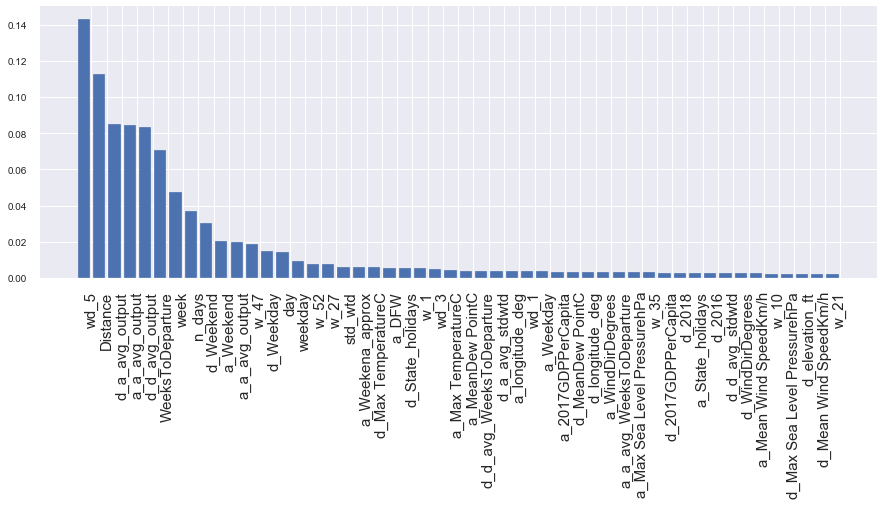

In [277]:
# Looking at the importance of each column and the prediction 
X_columns = X_array.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(reg.reg.feature_importances_)[::-1][:50]

importances = reg.reg.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [286]:
gradient_params = {
    'n_estimators':[250,275,300], 
    'max_depth':[4,5,7]}
model_boost = {
    'GradientBoost': GridSearchCV(
        GradientBoostingRegressor(min_samples_leaf = 5),
        param_grid = gradient_params, 
        scoring = "neg_mean_squared_error").fit(X_array, y_array).best_estimator_}

In [287]:
model_boost

{'GradientBoost': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='ls', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False)}

In [285]:
gradient_params = {
    'min_samples_leaf' : [5,5,6]}

model_boost2 = {
    'GradientBoost': GridSearchCV(GradientBoostingRegressor(n_estimators = 300, max_depth = 5, min_samples_split = 10),
                                  param_grid = gradient_params,
                                  scoring = "neg_mean_squared_error").fit(X_array, y_array).best_estimator_}

In [284]:
model_boost2

{'GradientBoost': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='ls', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=5, min_samples_split=10,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False)}

In [76]:
forest_params = {'n_estimators':[205,215,225]}
model_random = {'RandomForestRegressor': GridSearchCV(RandomForestRegressor(),param_grid=forest_params).fit(X_array, y_array).best_estimator_,}

In [77]:
model_random

{'RandomForestRegressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=205,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)}

### Getting the last external data to date - Changes with time

In [123]:
external_data_test = pd.read_csv("submissions/sarvic_2511_morning/external_data.csv")
# A bunch of useful tests to run before submitting external data
external_data_test.isna().sum()
# pd.to_datetime(external_data["Date"])

Date                         0
AirPort                      0
Max TemperatureC             0
MeanDew PointC               0
Max Humidity                 0
Max Sea Level PressurehPa    0
Max VisibilityKm             0
Mean VisibilityKm            0
Min VisibilitykM             0
Max Wind SpeedKm/h           0
Mean Wind SpeedKm/h          0
Precipitationmm              0
CloudCover                   0
WindDirDegrees               0
Rain                         0
Thunderstorm                 0
Fog                          0
Snow                         0
Hail                         0
Tornado                      0
latitude_deg                 0
longitude_deg                0
elevation_ft                 0
2018                         0
2017                         0
2016                         0
2015                         0
2017GDPPerCapita             0
Weekday                      0
Weekend                      0
Weekend_approx               0
Busiest_top5                 0
National

### Getting the best external data to date and adding my new features - Changes with time

In [21]:
external_data2 = pd.read_csv("submissions/sarvic_2311_1920_merge_de_nos_versions/external_data.csv")
external_data2.isna().sum()

Date                         0
AirPort                      0
Max TemperatureC             0
MeanDew PointC               0
Max Humidity                 0
Max Sea Level PressurehPa    0
Max VisibilityKm             0
Mean VisibilityKm            0
Min VisibilitykM             0
Max Wind SpeedKm/h           0
Mean Wind SpeedKm/h          0
Precipitationmm              0
CloudCover                   0
WindDirDegrees               0
Rain                         0
Thunderstorm                 0
Fog                          0
Snow                         0
Hail                         0
Tornado                      0
latitude_deg                 0
longitude_deg                0
elevation_ft                 0
2018                         0
2017                         0
2016                         0
2015                         0
2017GDPPerCapita             0
Weekday                      0
Weekend                      0
Weekend_approx               0
Busiest_top5                 0
National

In [1016]:
# Augmenting it with the new columns from my external data
external_data2["HigherTraffic_Dates"] = external_data["HigherTraffic_Dates"]
external_data2["M"] = external_data["M"]
external_data2["N"] = external_data["N"]
external_data2["S"] = external_data["S"]
external_data2["W"] = external_data["W"]

In [1017]:
# Printing the new external file data
external_data_new = external_data_fortest.to_csv('external_data.csv', index = None, header=True) 
#Don't forget to add '.csv' at the end of the path
print(external_data_new)

None


### Testing the file

In [282]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   rmse       time
	train  0.170  19.186673
	valid  0.388   5.143099
	test   0.417   1.429509
CV fold 1
	score   rmse       time
	train  0.172  18.708668
	valid  0.400   5.549801
	test   0.426   1.424471
CV fold 2
	score   rmse       time
	train  0.168  19.026289
	valid  0.393   5.129870
	test   0.419   1.406504
CV fold 3
	score   rmse       time
	train  0.172  18.594119
	valid  0.401   5.104433
	test   0.412   1.410818
CV fold 4
	score   rmse       time
	train  0.174  19.020283
	valid  0.386   5.148818
	test   0.408   1.457884
CV fold 5
	score   rmse       time
	train  0.179  18.574284
	valid  0.381   5.129669
	test   0.409   1.420711
CV fold 6
	score   rmse       time
	train  0.174  18.679153
	valid  0.388   5.167388
	test   0.401   1.415580
CV fold 7
	score   rmse       time
	train  0.170  18.985206
	valid  0.384   5.226972
	te